In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Prepare data
import torchvision
import torchvision.transforms as transforms
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datasets
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#hemDatTest = HemorrhageDataset("rsna-intracranial-hemorrhage-detection-png/test_images", "subdataset_test.csv", normal_transform, False, True)
#hemDatTrain = HemorrhageDataset("rsna-intracranial-hemorrhage-detection-png/train_images", "subdataset_train.csv", normal_transform, False, False)
DATA_MEAN = (0.5, 0.5, 0.5)		# define the mean for the scaling transform - PIL images already come given in
DATA_STD = (0.5, 0.5, 0.5)
train_transform = transforms.Compose(
    [
        transforms.Resize((96, 96)),
        transforms.ToTensor()

    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((96, 96)),
        transforms.ToTensor()
    ]
)
import albumentations as A
from albumentations.pytorch import ToTensorV2

special_transform = A.Compose([
    A.Resize(height=96, width=96, p=1),
    A.Rotate(p=0.5, limit=15),
    A.HorizontalFlip(p=0.5),
     A.CoarseDropout(
     num_holes_range=(3, 6),
     hole_height_range=(10, 15),
     hole_width_range=(10, 15),
     fill=0,
     p=0.5
    ),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20,  p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.3),
    ToTensorV2()
])

train_images3 = torchvision.datasets.ImageFolder(root="/kaggle/input/hw2-ml/land_patches-2/land_patches-2/train", transform=train_transform)
test_images3 = torchvision.datasets.ImageFolder(root="/kaggle/input/hw2-ml/land_patches-2/land_patches-2/test", transform=train_transform)
val_images3 = torchvision.datasets.ImageFolder(root="/kaggle/input/hw2-ml/land_patches-2/land_patches-2/val", transform=train_transform)


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [34]:
import os
files = os.listdir("/kaggle/input/hw2-ml/land_patches-2/land_patches-2/train")
sorted_files = sorted(files)
for idx, files in enumerate(sorted_files):
    for i in range(len(files)-1, -1, -1):
        if files[i].isupper():
            str_name = ""
            if files[0] != files[i]:
                str_name = files[0]
            sorted_files[idx] = str_name+files[i:]
            break
print(sorted_files)



['ACrop', 'Forest', 'HVegetation', 'Highway', 'Industrial', 'Pasture', 'PCrop', 'Residential', 'River', 'SLake']


In [35]:
files = os.listdir("/kaggle/input/hw2-ml/land_patches-2/land_patches-2/train")


In [36]:
from torch.utils.data import Dataset

class Dataset2(Dataset):
    def __init__(self, path_images, images, transform):
        self.images = images
        self.file_location = path_images
        self.transform = len(self.file_location) * [transform]



    def __len__(self):
        return len(self.file_location)


    def __apply_filter__(self, image, image_id, not_display=True):
        image.resize((96, 96))
        image = np.array(image, dtype='float32')/255.0
        new_image = self.transform[image_id](image=image)['image']

        return new_image


    def __getitem__(self, image_id):
        img_path = f"{self.file_location[image_id]}"
        img = PIL.Image.open(img_path)
        new_image = self.__apply_filter__(img, image_id)
        return new_image, self.images[image_id][1]

In [37]:
MAX_IMAGES = 10
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import torch
import torch.nn as nn

# Definirea mediului pe care va rula codul de antrenare
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running code @ {device}')

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import pylab as pl
from IPython import display

import collections
import enum
import warnings
warnings.filterwarnings('ignore')
def gallery(images, i, no_elements_per_class, title='Input images'):
    class_dict = sorted_files
    
    num_frames = len(images)
    
    h, w, num_channels = images[0][0].T.shape
    num_frames = min(num_frames, MAX_IMAGES)
    ff, axes = plt.subplots(1, num_frames, figsize=(num_frames, 1), subplot_kw={'xticks': [],'yticks': []})
    ff.tight_layout()

    idx_elements = random.sample(list(range((i-1)*no_elements_per_class, i*no_elements_per_class)), num_frames)
    for idx, i in enumerate(idx_elements):
        if num_channels == 3:
            axes[idx].imshow(images[i][0].T)
        else:
            axes[idx].imshow(images[i][0].T, cmap='gray')
        axes[idx].set_title(class_dict[images[i][1]])
        plt.setp(axes[idx].get_xticklabels(), visible=False)
        plt.setp(axes[idx].get_yticklabels(), visible=False)

    ff.subplots_adjust(wspace=2.0)
    plt.show()

Running code @ cpu


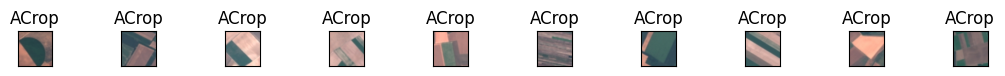

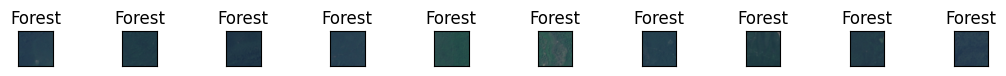

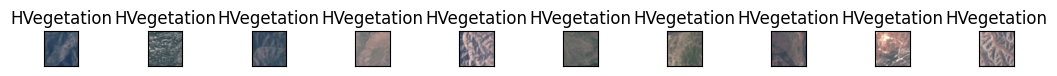

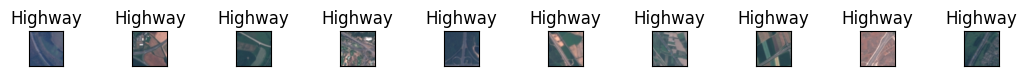

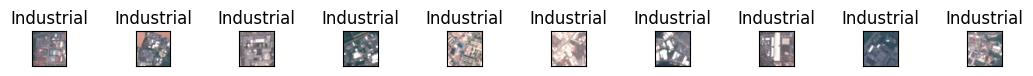

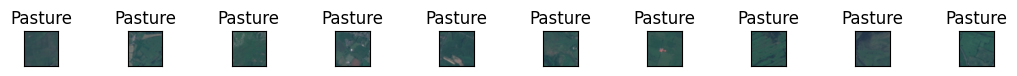

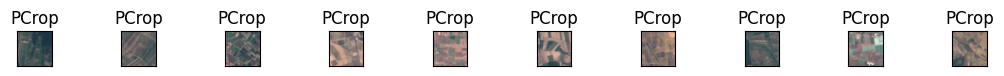

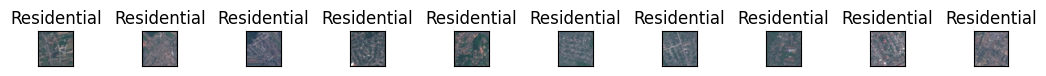

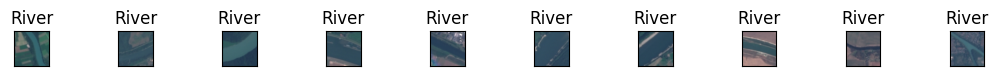

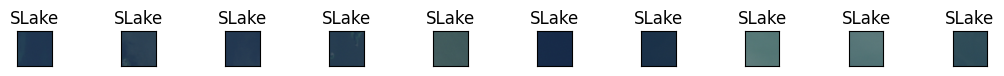

In [38]:
import random
for i in list(set(train_images3.targets)):
    gallery(train_images3, i+1, len(train_images3)//len(list(set(train_images3.targets))))

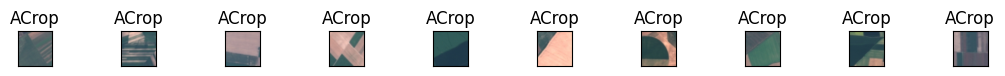

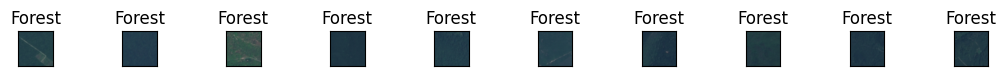

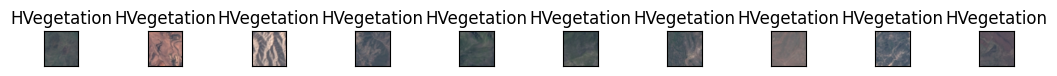

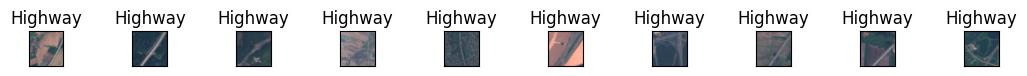

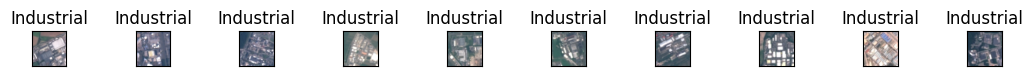

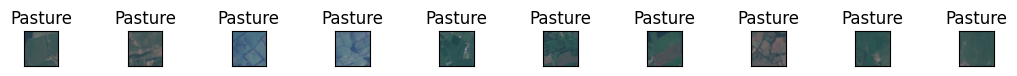

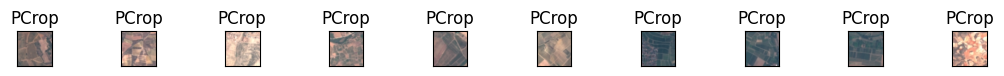

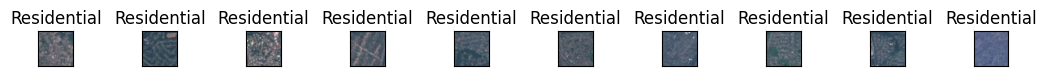

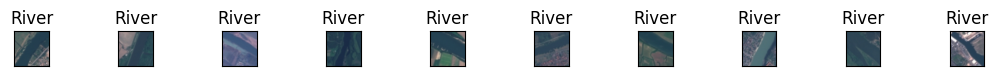

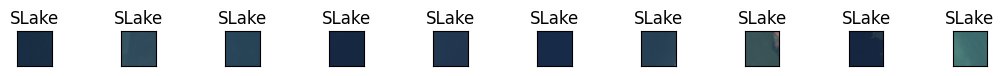

In [39]:
import random
for i in list(set(train_images3.targets)):
    gallery(val_images3, i+1, len(val_images3)//len(list(set(val_images3.targets))))

The lakes have different colours, which may be confusing, also some residential areas can be quite complex due to a lot of textures

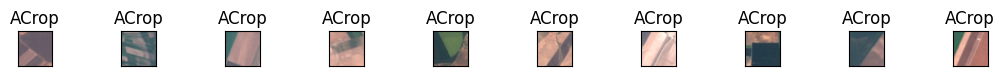

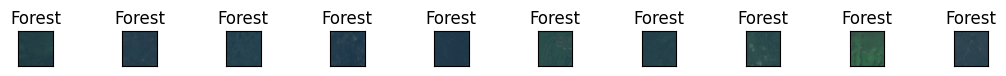

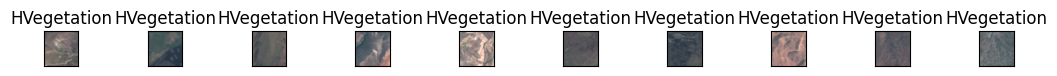

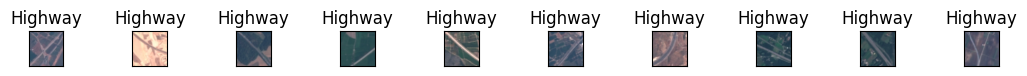

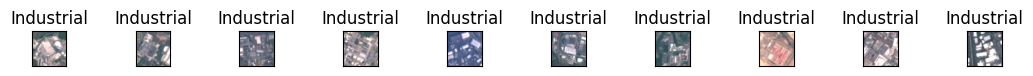

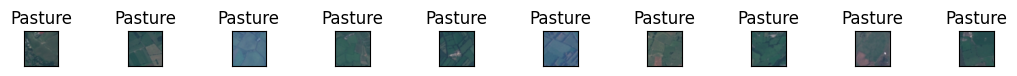

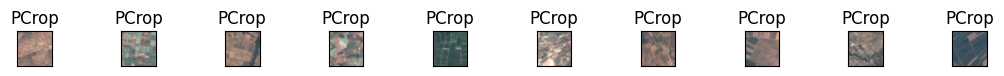

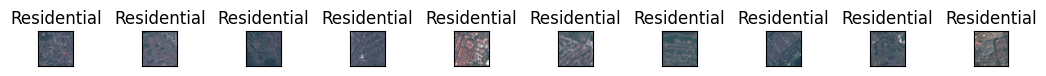

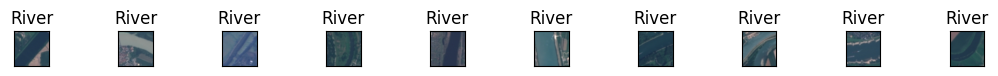

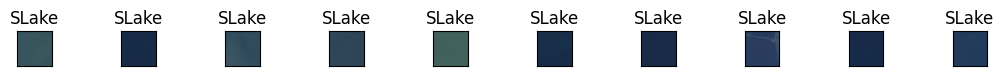

In [40]:
import random
for i in list(set(test_images3.targets)):
    gallery(test_images3, i+1, len(test_images3)//len(list(set(test_images3.targets))))

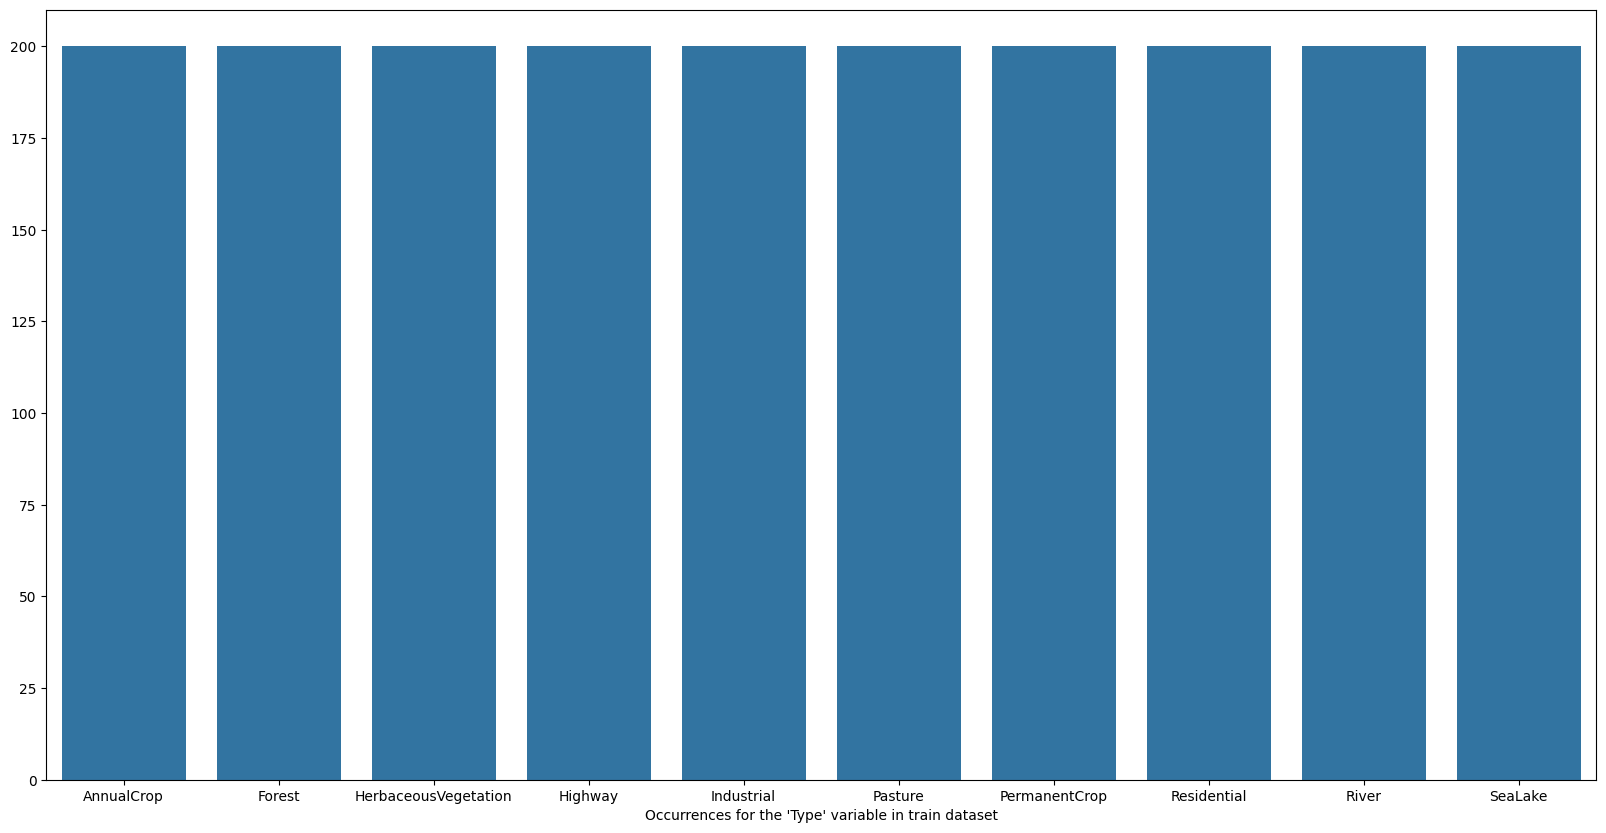

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
val, cnt = np.unique(train_images3.targets, return_counts=True)
files = sorted(files)
val = files
plt.figure(figsize=(20, 10))

plt.xlabel(f"Occurrences for the 'Type' variable in train dataset")
sns.barplot(x=val, y=cnt)
plt.show()

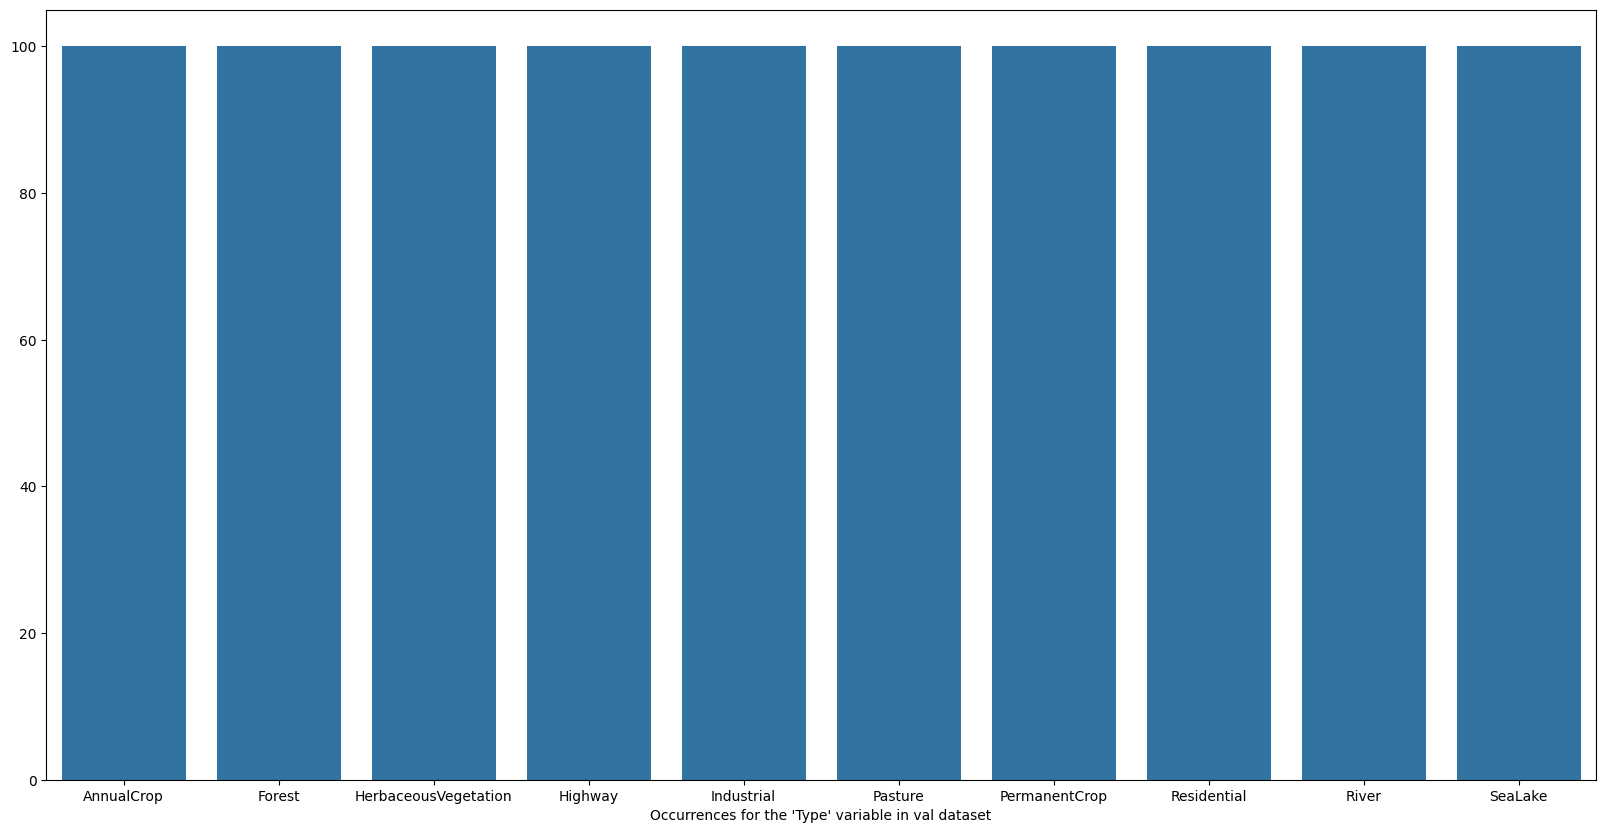

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
val, cnt = np.unique(val_images3.targets, return_counts=True)
val = files
plt.figure(figsize=(20, 10))

plt.xlabel(f"Occurrences for the 'Type' variable in val dataset")
sns.barplot(x=val, y=cnt)
plt.show()

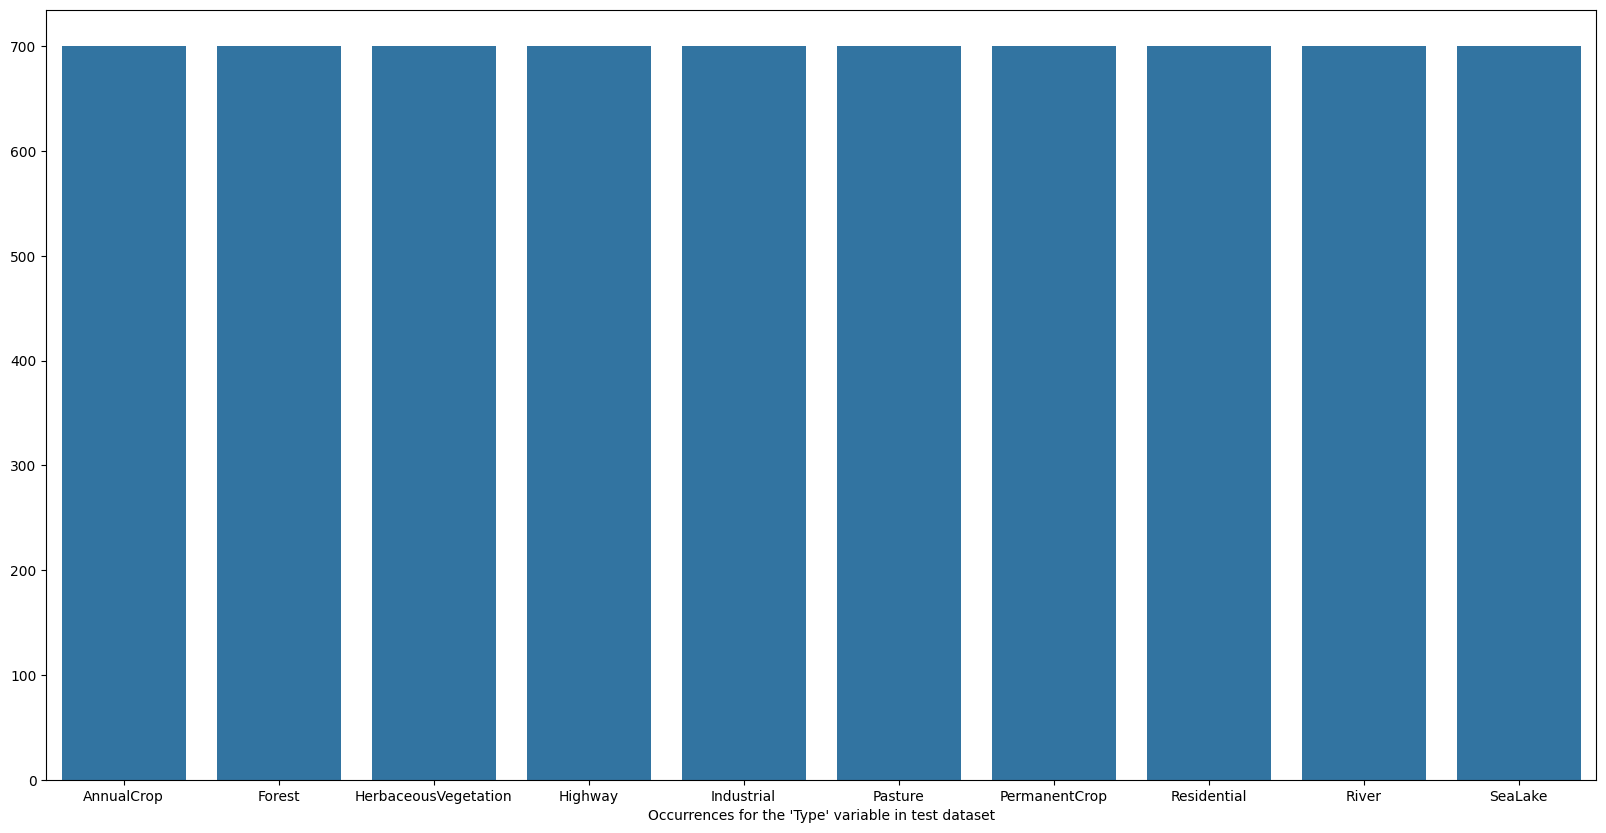

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
val, cnt = np.unique(test_images3.targets, return_counts=True)
val = files
plt.figure(figsize=(20, 10))

plt.xlabel(f"Occurrences for the 'Type' variable in test dataset")
sns.barplot(x=val, y=cnt)
plt.show()

In [44]:
# Plotting library.
from matplotlib import pyplot as plt
import pylab as pl
from IPython import display

import collections
import enum
import warnings
warnings.filterwarnings('ignore')
def gallery2(images, no_of_classes, title='Input images'):
    class_dict = sorted_files
    num_frames = len(images)
    h, w, num_channels = images[0][0].T.shape
    num_frames = min(num_frames, MAX_IMAGES)
    ff, axes = plt.subplots(1, num_frames, figsize=(num_frames, 1), subplot_kw={'xticks': [],'yticks': []})
    plt.tight_layout()
    idx_el = []
    for i in range(1, no_of_classes+1):
        idx_el.append(random.choice(list(range((i-1)*(int)(len(images)/no_of_classes), i*(int)(len(images)/no_of_classes)))))

    for idx, i in enumerate(idx_el):
        if num_channels == 3:
            axes[idx].imshow(images[i][0].T)
        else:
            axes[idx].imshow(images[i][0].T, cmap='gray')
        axes[idx].set_title(class_dict[images[i][1]])
        plt.setp(axes[idx].get_xticklabels(), visible=False)
        plt.setp(axes[idx].get_yticklabels(), visible=False)

    ff.subplots_adjust(wspace=0.1)
    plt.show()


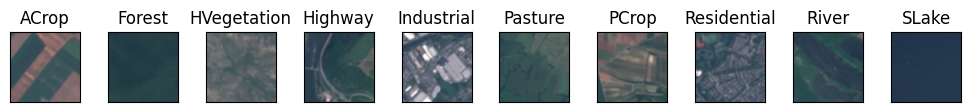

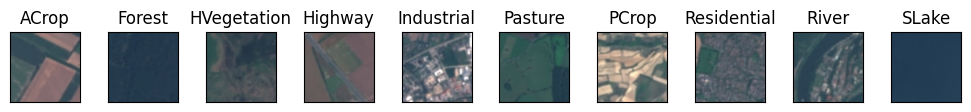

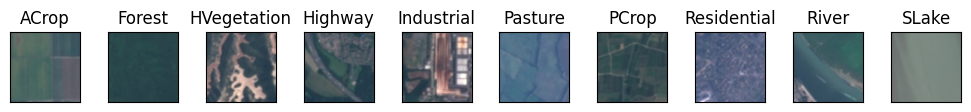

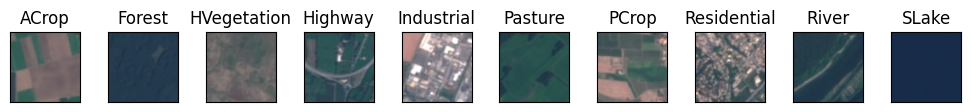

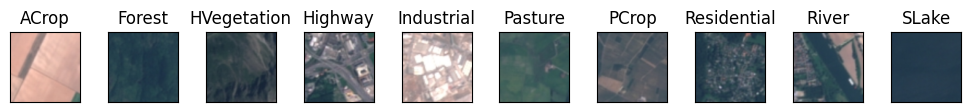

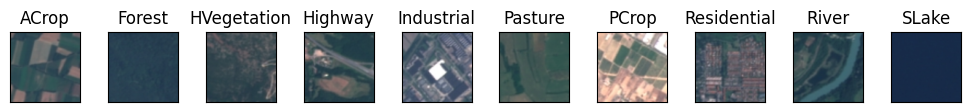

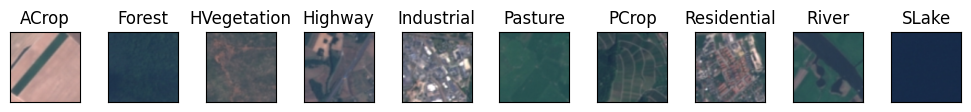

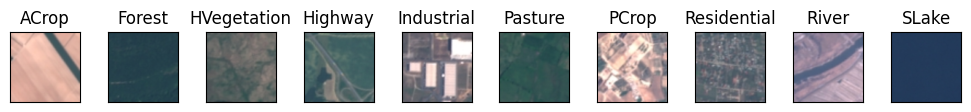

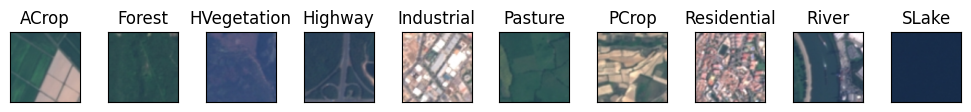

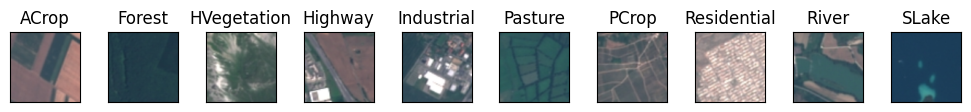

In [45]:
for i in range(10):
    gallery2(train_images3, len(list(set(train_images3.targets))))


The forest can be confused with lake, due to the simple textures, and similar color pallete(being both green)

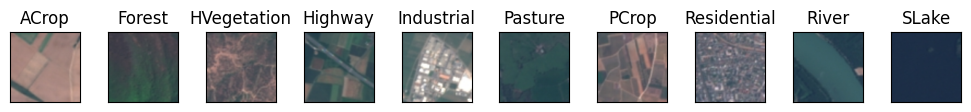

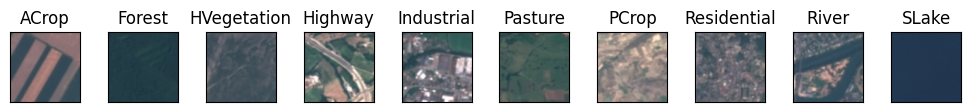

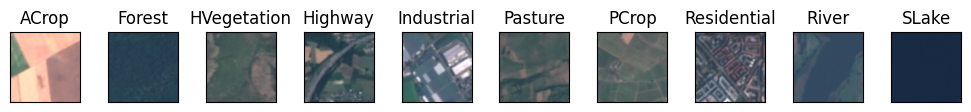

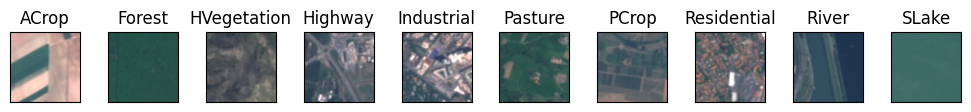

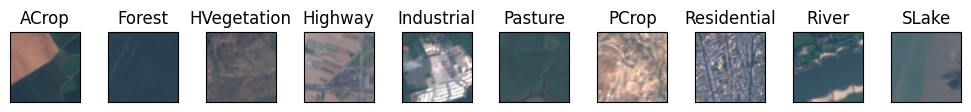

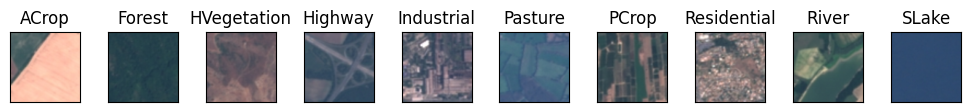

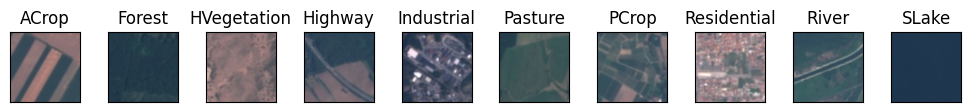

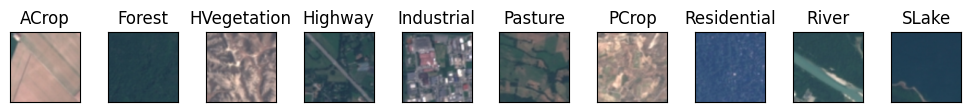

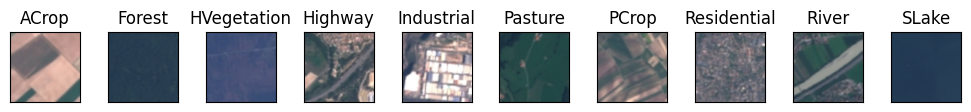

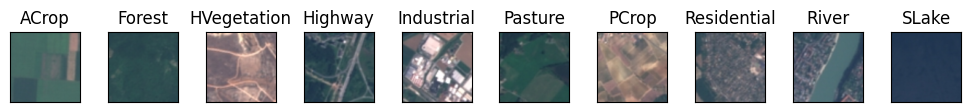

In [46]:
for i in range(10):
    gallery2(val_images3, len(list(set(val_images3.targets))))


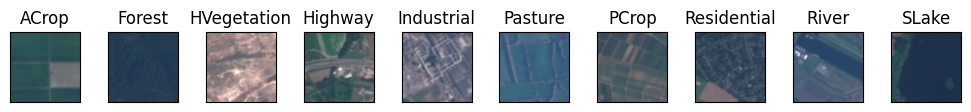

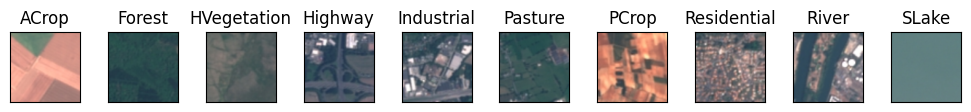

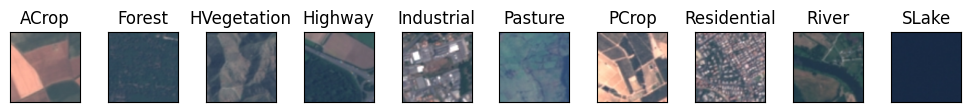

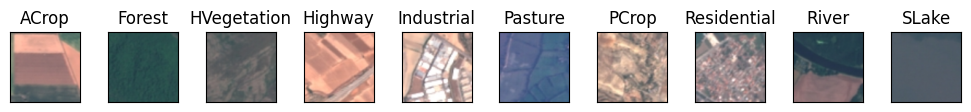

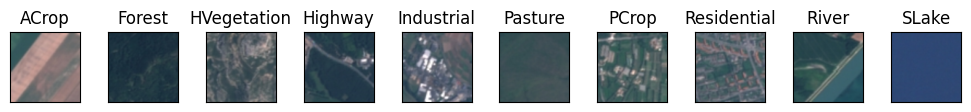

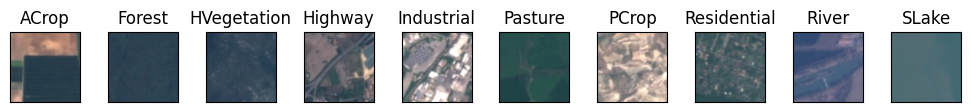

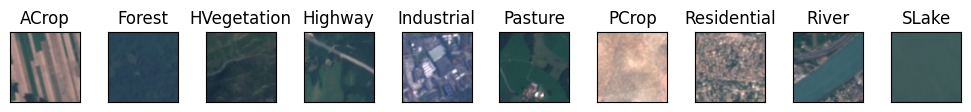

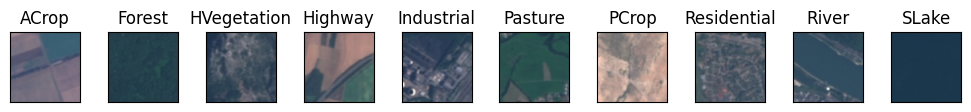

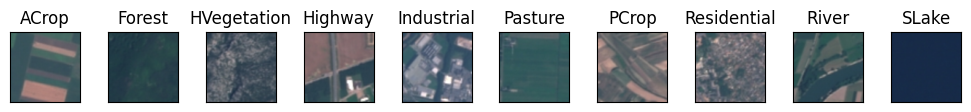

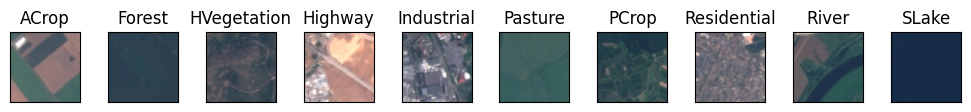

In [47]:
for i in range(10):
    gallery2(test_images3, len(list(set(test_images3.targets))))


Highways can be confused with with the river, pasture, due to some of the images, being situated near green areas. Same for Pasture and River

In [48]:
normal_transform = A.Compose([
    A.Resize(height=96, width=96, p=1),
    ToTensorV2()
])

In [49]:
list_path_train_images = list(map(lambda x: x[0], train_images3.samples))
list_path_val_images = list(map(lambda x: x[0], val_images3.samples))

In [50]:
import PIL

train_images4 = Dataset2(list_path_train_images, train_images3, special_transform)
val_images4 = Dataset2(list_path_val_images, val_images3, normal_transform)

In [51]:
model_name = "cnn" # @param['cnn', 'mlp', 'lenet', 'cnn_deep']
flag_batch_norm = 'ON'  # @param['ON', 'OFF']
flag_regularize = True     # @param['True', 'False'] {type:"raw"}


In [52]:
class MLP(nn.Module):
    def __init__(self, params):
        super(MLP, self).__init__()
        Cin,Hin,Win = params["shape_in"]
        num_classes = params["num_classes"]
        in_size = Cin*Hin*Win
        self.in_size = in_size
        self.fc1 = nn.Linear(in_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        #x = torch.flatten(x, 1)
        x = x.view(-1, self.in_size)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [53]:
class EmptyNorm(nn.Module):
    def __init__(self, *args, **kwargs):
        super(EmptyNorm, self).__init__()
        self._modules = dict()

    def forward(self, input):
        return input

In [54]:
'''This function can be useful in determining the output size of a convolutional layer in a neural network,
given the input dimensions and the convolutional layer's parameters.'''

def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [55]:
import torch.nn.functional as F

class CNN_(nn.Module):

    def __init__(self, params):

        super(CNN_, self).__init__()

        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]
        norm_layer=params["norm_layer"]

        self.norm1 = norm_layer(init_f)
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.norm2 = norm_layer(init_f*2)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.norm3 = norm_layer(init_f*4)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.norm4 = norm_layer(init_f*8)

        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)

        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        X = F.relu(self.norm1(self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.norm2(self.conv2(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.norm3(self.conv3(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.norm4(self.conv4(X)))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return X

In [56]:
def conv3x3(in_planes, out_planes, stride=1, padding=1):
    """
    3x3 2D convolution with padding=1
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    @:param padding: the padding to apply, default is 1 to keep width and height the same in the output activation maps
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """
    1x1 2D convolution
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


In [57]:
class ConvBlock(nn.Module):
    def __init__(self, bottleneck_channels, block_channels, norm_layer=EmptyNorm):
        super(ConvBlock, self).__init__()

        # first conv 1x1 layer which implements the bottlenecking
        self.conv1 = conv1x1(block_channels, bottleneck_channels)
        self.norm1 = norm_layer(bottleneck_channels)

        # conv 3x3 layer which applies the stride given as parameter
        self.conv2 = conv3x3(bottleneck_channels, bottleneck_channels)
        self.norm2 = norm_layer(bottleneck_channels)

        # conv 1x1 layer where the number of output channels is "expanded" according to the defined expansion factor
        # according to the above figure, the expansion factor is set to 4
        self.conv3 = conv1x1(bottleneck_channels, block_channels)
        self.norm3 = norm_layer(block_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        # first layer conv1 + bn1 + relu
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)

        # second layer conv2 + bn2 + relu
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu(out)

        # third layer conv3 + bn3
        out = self.conv3(out)
        out = self.norm3(out)

        # add identity to residual and apply relu
        out += identity
        out = self.relu(out)

        return out



In [58]:
class DeepConvNet(nn.Module):
    def __init__(self, params):
        super(DeepConvNet, self).__init__()


        Cin,Hin,Win = params["shape_in"]
        base_depth = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]
        norm_layer=params["norm_layer"]
        nr_layer_blocks = params["nr_layer_blocks"]
        expansion = params["expansion"]


        self.norm_layer = norm_layer
        self.base_depth = base_depth
        self.conv1 = nn.Conv2d(3, self.base_depth, kernel_size=7, stride=2, padding=3,
                               bias=False)  # image is now 16x16
        self.norm1 = norm_layer(self.base_depth)
        self.relu = nn.ReLU(inplace=True)

        # change to 64 channels base and image size 16x16
        depth1 = self.base_depth * expansion
        self.conv_depth1 = conv1x1(self.base_depth, depth1, stride=1)
        self.norm_depth1 = norm_layer(depth1)

        # #### Layer 1, 3 blocks
        self.layer1 = nn.Sequential(
            *[ConvBlock(self.base_depth, depth1, norm_layer=self.norm_layer)] * nr_layer_blocks
        )

        # change to 128 channels base and image size 8x8
        depth2 = depth1 * 2
        # TODO 3.1 - Definiti convolutia 2D cu kernel de dimensiune 1x1 care injumatateste imaginea
        self.conv_depth2 = conv1x1(depth1, depth2, stride=2)
        self.norm_depth2 = norm_layer(depth2)

        # #### Layer 2, 3 blocks
        # TODO 3.2 - Definiti secventa de ConvBlocks pentru Layer 2
        self.layer2 = nn.Sequential(
            *[ConvBlock(depth1, depth2, norm_layer=self.norm_layer)] * nr_layer_blocks
        )


        # change to 256 chanels and image size 4x4
        depth3 = depth2 * 2
        # TODO 3.3 - Definiti convolutia 2D cu kernel de dimensiune 1x1 care injumatateste imaginea
        self.conv_depth3 = conv1x1(depth2, depth3, stride=2)
        self.norm_depth3 = norm_layer(depth3)

        # Layer 3, 3 blocks
        # TODO 3.4 - Definiti secventa de ConvBlocks pentru Layer 3
        self.layer3 = nn.Sequential(
            *[ConvBlock(depth2, depth3, norm_layer=self.norm_layer)] * nr_layer_blocks
        )
        # AveragePooling
        # TODO 3.5 - Definiti straturile de GlobalAveragePooling si stratul Fully Connected
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(depth3, num_classes)
        self.flatten = nn.Flatten()

    '''
    ## 3. Definirea arhitecturii unei retele adanci - DeepConvNet

Implementarea propusă se inspira din modelele de tip [ResNet](https://d2l.ai/chapter_convolutional-modern/resnet.html).
Astfel, reteaua este construita dupa urmatorul sablon:
  * Conv2d(3, 16, k=7, stride=2, padding=3, bias=False) + Norm + ReLU
  * Conv2d(16, 64, k=1, stride=1) + Norm + ReLU
  * 3 x ConvBlock(16, 64, Norm)
  * Conv2d(64, 128, k=1, stride=2) + Norm + ReLU
  * 3 x ConvBlock(32, 128, Norm)
  * Conv2d(128, 256, k=1, stride=2) + Norm +ReLU
  * 3 x ConvBlock(64, 256, Norm)
  * [AdaptiveAveragePooling](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html)((1,1)) + Flatten
  * FC(256,10)
  '''
    def forward(self, x):
        # initial conv
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)

        # TODO 3.6 apply depth1 transform + layer 1
        x = self.conv_depth1(x)
        x = self.norm_depth1(x)
        x = self.relu(x)
        x = self.layer1(x)




        # TODO 3.7 apply depth2 transform + layer 2
        x = self.conv_depth2(x)
        x = self.norm_depth2(x)
        x = self.relu(x)
        x = self.layer2(x)

        # x = ...

        # TODO 3.8 apply depth3 transform + layer 3
        x = self.conv_depth3(x)
        x = self.norm_depth3(x)
        x = self.relu(x)
        x = self.layer3(x)

        # apply global average pooling + linearize + FC
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

In [59]:
params_model={
        "shape_in": (3,96,96),
        "initial_filters": 8,
        "num_fc1": 100,
        "dropout_rate": 0.4,
        "num_classes": 10,
        "norm_layer": nn.BatchNorm2d
}

cnn_model = CNN_(params_model)

device = torch.device("cpu")
model = cnn_model.to(device)

In [60]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 96, 96),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 94, 94]             224
       BatchNorm2d-2            [-1, 8, 94, 94]              16
            Conv2d-3           [-1, 16, 45, 45]           1,168
       BatchNorm2d-4           [-1, 16, 45, 45]              32
            Conv2d-5           [-1, 32, 20, 20]           4,640
       BatchNorm2d-6           [-1, 32, 20, 20]              64
            Conv2d-7             [-1, 64, 8, 8]          18,496
       BatchNorm2d-8             [-1, 64, 8, 8]             128
            Linear-9                  [-1, 100]         102,500
           Linear-10                   [-1, 10]           1,010
Total params: 128,278
Trainable params: 128,278
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 1.83
Params size (MB): 0.49
Estimated T

In [61]:
params_model={
        "shape_in": (3,96,96),
        "initial_filters": 16,
        "num_fc1": 100,
        "dropout_rate": 0.4,
        "num_classes": 10,
        "norm_layer": nn.BatchNorm2d,
        "nr_layer_blocks":3,
        "expansion": 4
}

cnn_model = DeepConvNet(params_model)
device = torch.device("cpu")
model = cnn_model.to(device)

In [62]:
summary(cnn_model, input_size=(3, 96, 96),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]           2,352
       BatchNorm2d-2           [-1, 16, 48, 48]              32
              ReLU-3           [-1, 16, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]           1,024
       BatchNorm2d-5           [-1, 64, 48, 48]             128
              ReLU-6           [-1, 64, 48, 48]               0
            Conv2d-7           [-1, 16, 48, 48]           1,024
       BatchNorm2d-8           [-1, 16, 48, 48]              32
              ReLU-9           [-1, 16, 48, 48]               0
           Conv2d-10           [-1, 16, 48, 48]           2,304
      BatchNorm2d-11           [-1, 16, 48, 48]              32
             ReLU-12           [-1, 16, 48, 48]               0
           Conv2d-13           [-1, 64, 48, 48]           1,024
      BatchNorm2d-14           [-1, 64,

In [63]:
params_model={
        "shape_in": (3,96,96),
        "num_classes": 10
}

cnn_model = MLP(params_model)

device = torch.device("cpu")
model = cnn_model.to(device)

In [64]:
summary(cnn_model, input_size=(3, 96, 96),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]       7,078,144
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 256]          65,792
              ReLU-4                  [-1, 256]               0
            Linear-5                   [-1, 10]           2,570
Total params: 7,146,506
Trainable params: 7,146,506
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.01
Params size (MB): 27.26
Estimated Total Size (MB): 27.38
----------------------------------------------------------------


In [65]:
# define dimension of the batches to sample from the datasets
BATCH_SIZE_TRAIN = 64  #@param
BATCH_SIZE_VAL = 64  #@param
NO_WORKERS = 8  #@param
SHUFFLE_DATA = True

# create Dataset iterator object using the data previously downloaded
# we shuffle the data and sample repeatedly batches for training
train_loader = torch.utils.data.DataLoader(train_images4, batch_size=BATCH_SIZE_TRAIN,
                                           shuffle=SHUFFLE_DATA,
                                           num_workers=NO_WORKERS)

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')


Shape of training images: torch.Size([64, 3, 96, 96])
Shape of training labels: torch.Size([64])


In [66]:
# we do the same for test dataset
val_loader = torch.utils.data.DataLoader(val_images4, batch_size=BATCH_SIZE_VAL,
                                          shuffle=SHUFFLE_DATA,
                                          num_workers=NO_WORKERS)

def loopy_val_loader(dl):
    data_iter = iter(dl)

    while True:
        try:
            yield next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            yield next(data_iter)

(batch_val_images, batch_val_labels) = next(iter(val_loader))
print(f'Shape of test images: {batch_val_images.size()}')
print(f'Shape of test labels: {batch_val_labels.size()}')


Shape of test images: torch.Size([64, 3, 96, 96])
Shape of test labels: torch.Size([64])


In [67]:
test_loader = torch.utils.data.DataLoader(test_images3, batch_size=BATCH_SIZE_VAL,
                                          shuffle=SHUFFLE_DATA,
                                          num_workers=NO_WORKERS)

In [68]:
# First define the preprocessing ops for the train/test data
crop_height = 32  # @param
crop_width = 32  # @param
NUM_CLASSES = 10  # @param


In [69]:
net = None                       # type: nn.Module
params_model2={
        "shape_in": (3,96,96),
        "num_classes": 10
  }

mlp = MLP(params_model2)
print("!!!",model_name, "!!!")
if model_name == "mlp":
  params_model={
        "shape_in": (3,96,96),
        "num_classes": 10
  }

  net = MLP(params_model)
elif model_name == "lenet":
  net = LeNet()
elif model_name == "cnn":

  if flag_batch_norm == "ON":
      params_model={
        "shape_in": (3,96,96),
        "initial_filters": 8,
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 10,
        "norm_layer": nn.BatchNorm2d
      }

      net = CNN_(params_model)
  else:
      params_model={
        "shape_in": (3,96,96),
        "initial_filters": 8,
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 10,
        "norm_layer": EmptyNorm
      }

      net = CNN_(params_model)
else:

  if flag_batch_norm == "ON":
      params_model={
        "shape_in": (3,96,96),
        "initial_filters": 16,
        "num_fc1": 100,
        "dropout_rate": 0.4,
        "num_classes": 10,
        "norm_layer": nn.BatchNorm2d,
        "nr_layer_blocks":3,
        "expansion": 4
      }

      net = DeepConvNet(params_model)
  else:
      params_model={
        "shape_in": (3,96,96),
        "initial_filters": 16,
        "num_fc1": 100,
        "dropout_rate": 0.4,
        "num_classes": 10,
        "norm_layer": EmptyNorm,
        "nr_layer_blocks":3,
        "expansion": 4
      }

      net = DeepConvNet(params_model)

net.train()               # Default after init is train
net = net.to(device)      # Move network to device

print(list(net.modules())[0])

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = net(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)

!!! cnn !!!
CNN_(
  (norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)
tensor([[ 0.0074, -0.1184, -0.0099, -0.0254, -0.0634,  0.1711, -0.0697, -0.1061,
          0.1146, -0.3138],
        [-0.3530, -0.1274,  0.6015,  0.2351, -0.1757, -0.0078,  0.2148,  0.2324,
         -0.2815,  0.1263]], grad_fn=<AddmmBackward0>)
tensor(

In [70]:
def top_k_accuracy(k, target, output):
    batch_size = target.size(0)

    _, pred = output.topk(k, 1, True, True)

    pred = pred.t()
    correct = pred.eq(target.to(device).view(1, -1).expand_as(pred))

    correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)

    return correct_k

In [71]:
lr_init = 0.001                # initial learning rate
lr_factor = 0.1             # learning rate decay factor
weight_decay_factor = 1e-4  # weight decay factor for L2 weight regularization
lr_schedule_milestones = [50e3, 75e3, 100e3]

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
#optimizer = torch.optim.SGD(net.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
optimizer = torch.optim.Adam(net.parameters(), lr=lr_init)

if flag_regularize:
    #optimizer = torch.optim.SGD(net.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr_init, weight_decay=weight_decay_factor)

# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

In [72]:
# Function that takes a list of losses and plots them.
REFRESH_EVERY = 1000

def plot_losses(loss_list, steps, ct):
    if ct % REFRESH_EVERY == 0:
        display.clear_output(wait=True)

    display.display(pl.gcf())
    pl.plot(steps, loss_list, c='b')
    #time.sleep(1.0)

In [73]:
# Define number of training iterations and reporting intervals
TRAIN_ITERS = 100e3  # @param
REPORT_TRAIN_EVERY = 100  # @param
PLOT_EVERY = 100  # @param
REPORT_VAL_EVERY = 200  # @param
VAL_ITERS = 100  # @param

In [74]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
def loss_batch(loss_func, output, target, opt=None, scaler=None):
    # zero the parameter gradients
    # forward + backward + optimize

    loss = loss_func(output, target)
    metric_b = top_k_accuracy(1, target, output)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None, scaler=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output

        loss_b,metric_b=loss_batch(loss_func, output, yb, opt, scaler=scaler) # get loss per batch
        run_loss+=loss_b
        t_metric+=metric_b

    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value

    return loss, metric

In [75]:
from tqdm.notebook import trange, tqdm
import time
time_current = None


def Train_Val(model, params,verbose=False, limit=False, s=None):

    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]

    loss_history={"train": [],"val": []}
    metric_history={"train": [],"val": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    early_stop_it = 0
    use_amp = True

    scaler = torch.amp.GradScaler("cpu", use_amp)

    for epoch in tqdm(range(epochs)):

        # Get the Learning Rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))


# Train Model Process


        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt, scaler=scaler)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        if (s!=None):
            global time_current
            time_current = time.time() - s


# Evaluate Model Process


        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl, scaler=scaler)

        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
            early_stop_it=0
        else:
            early_stop_it+=1

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        print(f"train loss: {float(train_loss):.6f}, dev loss: {float(val_loss):.6f}, accuracy: {100*(float(val_metric)):.2f}%")
        print("-"*10)


        #if limit and early_stop_it > 10:
            #break



    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history, best_model_wts

In [76]:
from torch import optim
import copy

from torch.optim.lr_scheduler import ReduceLROnPlateau
params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 100,
 "optimiser": optim.Adam(net.parameters(),lr=3e-4, weight_decay=1e-4),
 "lr_change": ReduceLROnPlateau(optim.Adam(net.parameters(),lr=3e-4, weight_decay=1e-4),
                                mode='min',
                                factor=0.5,
                                patience=4),
 "f_loss": nn.CrossEntropyLoss(label_smoothing=0.1),
 "weight_path": "weights.pt",
}

cnn_model,loss_hist,metric_hist,best_model_wts = Train_Val(net,params_train, verbose=True, limit=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99, current lr=0.0003
Copied best model weights!
train loss: 0.033724, dev loss: 0.036508, accuracy: 17.40%
----------
Epoch 1/99, current lr=0.0003
Copied best model weights!
train loss: 0.029685, dev loss: 0.028323, accuracy: 45.10%
----------
Epoch 2/99, current lr=0.0003
Copied best model weights!
train loss: 0.028168, dev loss: 0.025477, accuracy: 52.40%
----------
Epoch 3/99, current lr=0.0003
Copied best model weights!
train loss: 0.026635, dev loss: 0.024152, accuracy: 54.90%
----------
Epoch 4/99, current lr=0.0003
Copied best model weights!
train loss: 0.026228, dev loss: 0.023731, accuracy: 57.50%
----------
Epoch 5/99, current lr=0.0003
Copied best model weights!
train loss: 0.025255, dev loss: 0.023244, accuracy: 58.90%
----------
Epoch 6/99, current lr=0.0003
Copied best model weights!
train loss: 0.024615, dev loss: 0.022239, accuracy: 62.70%
----------
Epoch 7/99, current lr=0.0003
train loss: 0.024398, dev loss: 0.022963, accuracy: 59.40%
----------
Epoch 8/99,

In [77]:
loss_func = nn.CrossEntropyLoss()
test_loss, test_metric = loss_epoch(net,loss_func,test_loader)

print(f"Test loss: {test_loss}. Accurracy for test: {float(test_metric)*100}")

Test loss: 0.010684621146747043. Accurracy for test: 78.25714349746704


<Axes: >

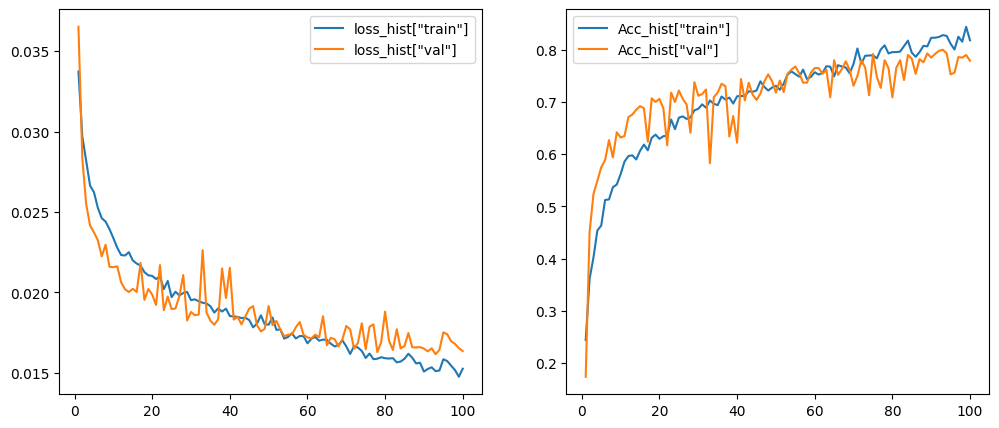

In [78]:
metric_train_hist = []
metric_val_hist = []
for i in range(len(metric_hist['train'])):
    metric_train_hist.append((float)(metric_hist['train'][i]))
for i in range(len(metric_hist['val'])):
    metric_val_hist.append((float)(metric_hist['val'][i]))
# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.lineplot(x=[*range(1,min(len(loss_hist["train"])+1, epochs+1))],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,min(len(loss_hist["val"])+1, epochs+1))],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,min(len(metric_train_hist)+1, epochs+1))],y=metric_train_hist,ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,min(len(metric_val_hist)+1, epochs+1))],y=metric_val_hist,ax=ax[1],label='Acc_hist["val"]')

In [79]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



# define function For Classification Report
import torch
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# define function For Classification Report
def Ture_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, pred = outputs.topk(1, 1, True, True)
        pred = pred.t()

        y_true.extend(labels)
        y_pred.extend(pred.detach().cpu())
    y_pred2 = []
    y_true2 = []
    for el in y_pred:
        y_pred2.extend(el.tolist())
    y_true = list(map(lambda x: int(x), y_true))


    return y_true, y_pred2

# check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)

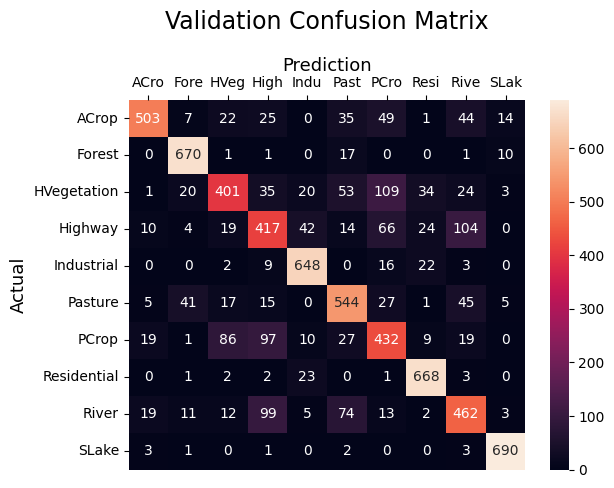

In [96]:
cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=list(map(lambda x: x[0:4], sorted_files)),
            yticklabels=sorted_files)
plt.ylabel('Actual', fontsize=13)
plt.title('Validation Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.show()

In [81]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
f1_score1 = f1_score(y_true, y_pred, average='macro')
accuracy_score1 = accuracy_score(y_true, y_pred)
precision_score1 = precision_score(y_true, y_pred, average='macro')
recall_score1 = recall_score(y_true, y_pred, average='macro')

In [82]:
y_true, y_pred = Ture_and_Pred(test_loader, cnn_model)

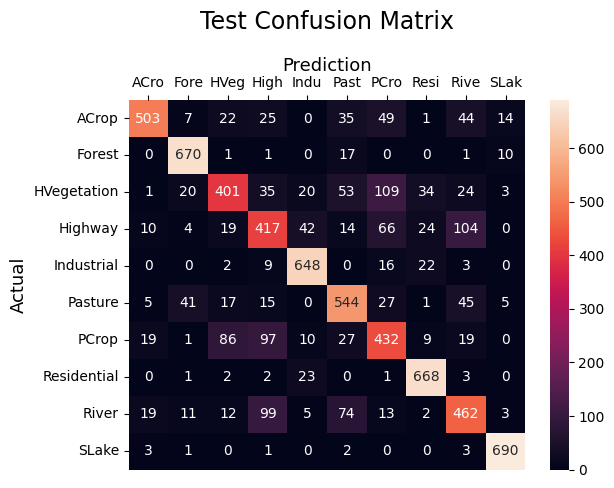

In [99]:
cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=list(map(lambda x: x[0:4], sorted_files)),
            yticklabels=sorted_files)
plt.ylabel('Actual', fontsize=13)
plt.title('Test Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.show()

In [84]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
f1_score2 = f1_score(y_true, y_pred, average='macro')
accuracy_score2 = accuracy_score(y_true, y_pred)
precision_score2 = precision_score(y_true, y_pred, average='macro')
recall_score2 = recall_score(y_true, y_pred, average='macro')

In [85]:
params_model={
        "shape_in": (3,96,96),
        "initial_filters": 8,
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 10,
        "norm_layer": nn.BatchNorm2d
      }

cnn_model0 = CNN_(params_model)
cnn_model02 = CNN_(params_model)

In [86]:
cnn_model0.load_state_dict(best_model_wts)
cnn_model02.load_state_dict(best_model_wts)


<All keys matched successfully>

In [104]:
from torch import optim
import copy

from torch.optim.lr_scheduler import ReduceLROnPlateau




for name, layer in cnn_model0.named_children():
   if "fc" not in name:
       for param in layer.parameters():
            param.requires_grad = False



cnn_model0 = cnn_model0.to(device)

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 50,
 "optimiser": optim.Adam(filter(lambda p: p.requires_grad, cnn_model.parameters()),lr=3e-4, weight_decay=1e-4),
 "lr_change": ReduceLROnPlateau(optim.Adam(filter(lambda p: p.requires_grad, cnn_model.parameters()),lr=3e-4, weight_decay=1e-4),
                                mode='min',
                                factor=0.5,
                                patience=4),
 "f_loss": nn.CrossEntropyLoss(label_smoothing=0.1),
 "weight_path": "weights2.pt",
}
cnn_model_frozen2,loss_hist_2,metric_hist_2,best_model_wts_2 = Train_Val(cnn_model0,params_train, verbose=True, limit=True)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/49, current lr=0.0003
Copied best model weights!
train loss: 0.015154, dev loss: 0.015926, accuracy: 79.30%
----------
Epoch 1/49, current lr=0.0003
train loss: 0.015223, dev loss: 0.016487, accuracy: 78.90%
----------
Epoch 2/49, current lr=0.0003
train loss: 0.015380, dev loss: 0.016427, accuracy: 78.90%
----------
Epoch 3/49, current lr=0.0003
train loss: 0.015169, dev loss: 0.016496, accuracy: 78.90%
----------
Epoch 4/49, current lr=0.0003
train loss: 0.015306, dev loss: 0.016285, accuracy: 78.80%
----------
Epoch 5/49, current lr=0.0003
train loss: 0.015406, dev loss: 0.016382, accuracy: 78.70%
----------
Epoch 6/49, current lr=0.0003
train loss: 0.015294, dev loss: 0.016401, accuracy: 77.60%
----------
Epoch 7/49, current lr=0.0003
train loss: 0.015443, dev loss: 0.016286, accuracy: 79.70%
----------
Epoch 8/49, current lr=0.0003
train loss: 0.015186, dev loss: 0.016403, accuracy: 78.90%
----------
Epoch 9/49, current lr=0.0003
train loss: 0.014969, dev loss: 0.016313, a

In [105]:
loss_func = nn.CrossEntropyLoss()
test_loss, test_metric = loss_epoch(cnn_model_frozen2,loss_func,test_loader)

print(f"Test loss: {test_loss}. Accurracy for test: {float(test_metric)*100}")

Test loss: 0.01049481964962823. Accurracy for test: 78.37142944335938


<Axes: >

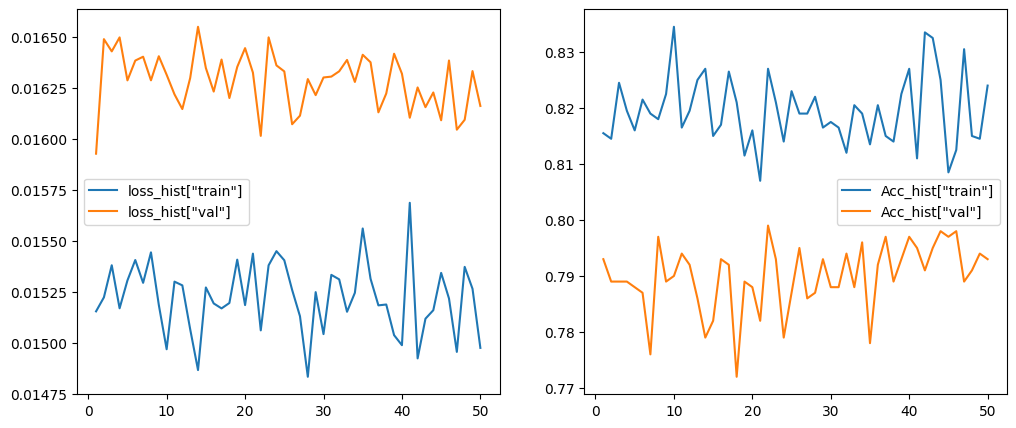

In [106]:
metric_train_hist = []
metric_val_hist = []
for i in range(len(metric_hist_2['train'])):
    metric_train_hist.append((float)(metric_hist_2['train'][i]))
for i in range(len(metric_hist_2['val'])):
    metric_val_hist.append((float)(metric_hist_2['val'][i]))

# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.lineplot(x=[*range(1,len(loss_hist_2["train"])+1)],y=loss_hist_2["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,len(loss_hist_2["val"])+1)],y=loss_hist_2["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,len(metric_train_hist)+1)],y=metric_train_hist,ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,len(metric_val_hist)+1)],y=metric_val_hist,ax=ax[1],label='Acc_hist["val"]')

In [107]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



# define function For Classification Report
import torch
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# define function For Classification Report
def Ture_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, pred = outputs.topk(1, 1, True, True)
        pred = pred.t()

        y_true.extend(labels)
        y_pred.extend(pred.detach().cpu())
    y_pred2 = []
    y_true2 = []
    for el in y_pred:
        y_pred2.extend(el.tolist())
    y_true2 = list(map(lambda x: int(x), y_true))


    return y_true2, y_pred2

# check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model_frozen2)

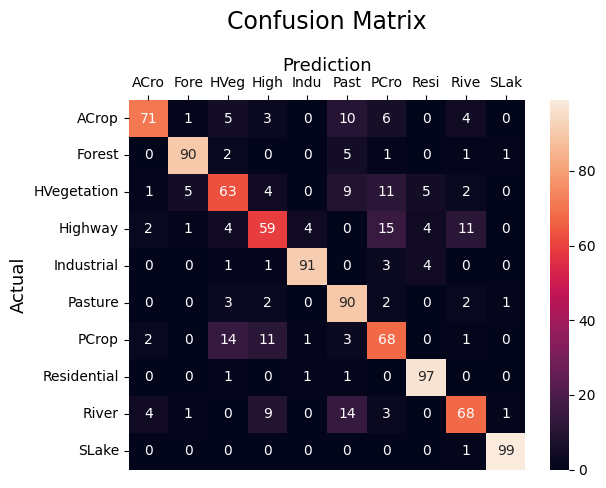

In [108]:
cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=list(map(lambda x: x[0:4], sorted_files)),
            yticklabels=sorted_files)
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.show()

In [109]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
f1_score9 = f1_score(y_true, y_pred, average='macro')
accuracy_score9 = accuracy_score(y_true, y_pred)
precision_score9 = precision_score(y_true, y_pred, average='macro')
recall_score9 = recall_score(y_true, y_pred, average='macro')

In [111]:
y_true2, y_pred2 = Ture_and_Pred(test_loader, cnn_model_frozen2)

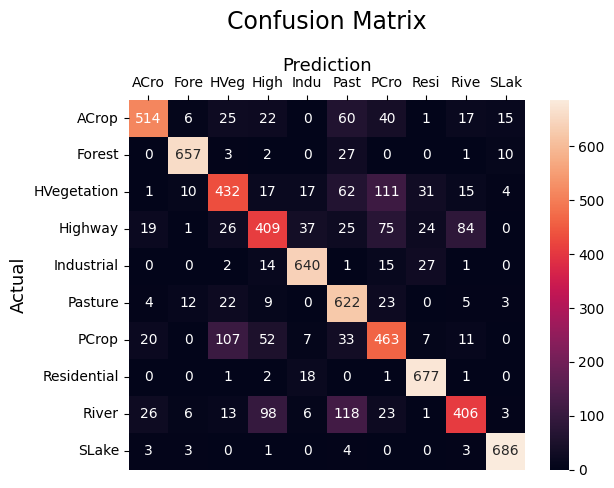

In [112]:
cm = confusion_matrix(y_true2,y_pred2)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=list(map(lambda x: x[0:4], sorted_files)),
            yticklabels=sorted_files)
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.show()

In [113]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
f1_score10 = f1_score(y_true2, y_pred2, average='macro')
accuracy_score10 = accuracy_score(y_true2, y_pred2)
precision_score10 = precision_score(y_true2, y_pred2, average='macro')
recall_score10 = recall_score(y_true2, y_pred2, average='macro')

In [114]:
end_layers = []
start_layers = []
list_elements = []
for name, layer in cnn_model.named_children():
   if "fc" not in name:
     start_layers.append(layer.parameters())
     list_elements.append({"params": layer.parameters(), "lr":3e-6})
   else:
     end_layers.append(layer.parameters())
     list_elements.append({"params": layer.parameters(), "lr":3e-4})


In [115]:
if torch.cuda.device_count() > 1: 
    cnn_model02 = nn.DataParallel(cnn_model02)
cnn_model02 = cnn_model02.to(device)

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 50,
 "optimiser": optim.Adam(list_elements, weight_decay=1e-4),
 "lr_change": ReduceLROnPlateau(optim.Adam(list_elements, weight_decay=1e-4),
                                mode='min',
                                factor=0.5,
                                patience=4),
 "f_loss": nn.CrossEntropyLoss(label_smoothing=0.1),
 "weight_path": "weights3.pt",
}
cnn_model_frozen,loss_hist_,metric_hist_,best_model_wts_ = Train_Val(cnn_model02,params_train, verbose=True, limit=True)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/49, current lr=3e-06
Copied best model weights!
train loss: 0.015490, dev loss: 0.016153, accuracy: 79.70%
----------
Epoch 1/49, current lr=3e-06
Copied best model weights!
train loss: 0.015160, dev loss: 0.015983, accuracy: 78.70%
----------
Epoch 2/49, current lr=3e-06
train loss: 0.015047, dev loss: 0.016278, accuracy: 79.60%
----------
Epoch 3/49, current lr=3e-06
train loss: 0.015515, dev loss: 0.016081, accuracy: 77.80%
----------
Epoch 4/49, current lr=3e-06
train loss: 0.015035, dev loss: 0.016423, accuracy: 78.40%
----------
Epoch 5/49, current lr=3e-06
train loss: 0.015025, dev loss: 0.016401, accuracy: 79.20%
----------
Epoch 6/49, current lr=3e-06
Loading best model weights!
train loss: 0.015300, dev loss: 0.016373, accuracy: 78.90%
----------
Epoch 7/49, current lr=1.5e-06
train loss: 0.015282, dev loss: 0.016504, accuracy: 78.10%
----------
Epoch 8/49, current lr=1.5e-06
train loss: 0.015006, dev loss: 0.016287, accuracy: 78.50%
----------
Epoch 9/49, current lr=

In [116]:
loss_func = nn.CrossEntropyLoss()
test_loss, test_metric = loss_epoch(cnn_model_frozen,loss_func,test_loader)

print(f"Test loss: {test_loss}. Accurracy for test: {float(test_metric)*100}")

Test loss: 0.010451915187495095. Accurracy for test: 78.47142815589905


In [117]:
metric_train_hist = []
metric_val_hist = []
for i in range(len(metric_hist['train'])):
    metric_train_hist.append((float)(metric_hist['train'][i]))
for i in range(len(metric_hist['val'])):
    metric_val_hist.append((float)(metric_hist['val'][i]))

In [118]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



# define function For Classification Report
import torch
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# define function For Classification Report
def Ture_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, pred = outputs.topk(1, 1, True, True)
        pred = pred.t()

        y_true.extend(labels)
        y_pred.extend(pred.detach().cpu())
    y_pred2 = []
    y_true2 = []
    for el in y_pred:
        y_pred2.extend(el.tolist())
    y_true2 = list(map(lambda x: int(x), y_true))


    return y_true2, y_pred2

# check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model_frozen)

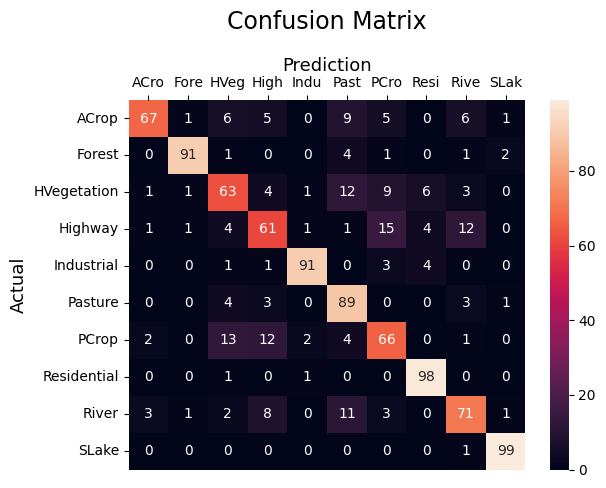

In [119]:
cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=list(map(lambda x: x[0:4], sorted_files)),
            yticklabels=sorted_files)
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.show()

In [120]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
f1_score3 = f1_score(y_true, y_pred, average='macro')
accuracy_score3 = accuracy_score(y_true, y_pred)
precision_score3 = precision_score(y_true, y_pred, average='macro')
recall_score3 = recall_score(y_true, y_pred, average='macro')

In [121]:
y_true2, y_pred2 = Ture_and_Pred(test_loader, cnn_model_frozen)

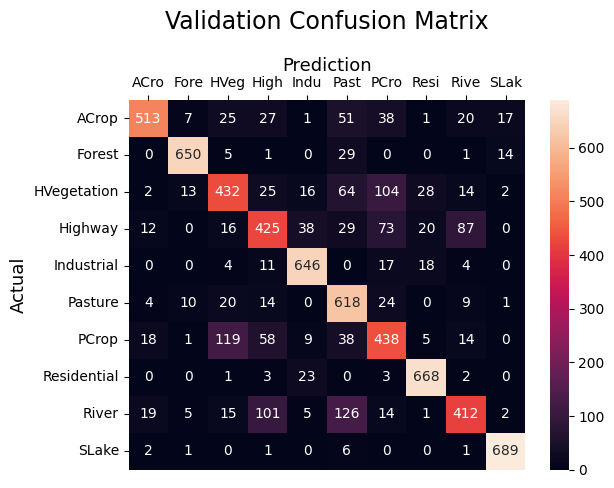

In [122]:
cm = confusion_matrix(y_true2,y_pred2)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=list(map(lambda x: x[0:4], sorted_files)),
            yticklabels=sorted_files)
plt.ylabel('Actual', fontsize=13)
plt.title('Validation Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.show()

In [123]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
f1_score4 = f1_score(y_true2, y_pred2, average='macro')
accuracy_score4 = accuracy_score(y_true2, y_pred2)
precision_score4 = precision_score(y_true2, y_pred2, average='macro')
recall_score4 = recall_score(y_true2, y_pred2, average='macro')

<Axes: >

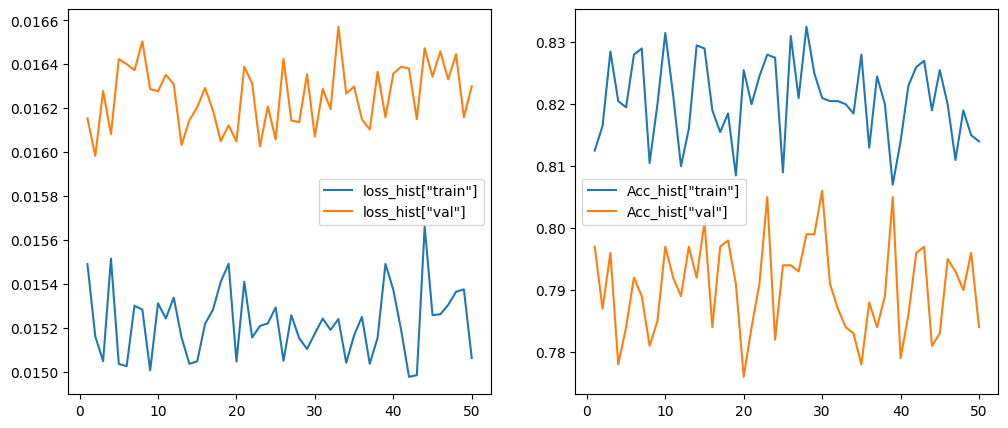

In [124]:
metric_train_hist2 = []
metric_val_hist2 = []
for i in range(len(metric_hist_['train'])):
    metric_train_hist2.append((float)(metric_hist_['train'][i]))
for i in range(len(metric_hist_['val'])):
    metric_val_hist2.append((float)(metric_hist_['val'][i]))

# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.lineplot(x=[*range(1,len(loss_hist_["train"])+1)],y=loss_hist_["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,len(loss_hist_["val"])+1)],y=loss_hist_["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,len(metric_train_hist2)+1)],y=metric_train_hist2,ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,len(metric_val_hist2)+1)],y=metric_val_hist2,ax=ax[1],label='Acc_hist["val"]')

In [125]:
from torch import optim
import copy

from torch.optim.lr_scheduler import ReduceLROnPlateau


if torch.cuda.device_count() > 1: 
    mlp = nn.DataParallel(mlp)
mlp = mlp.to(device)
params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 100,
 "optimiser": optim.Adam(mlp.parameters(),lr=3e-4, weight_decay=1e-4),
 "lr_change": ReduceLROnPlateau(optim.Adam(mlp.parameters(),lr=3e-4, weight_decay=1e-4),
                                mode='min',
                                factor=0.5,
                                patience=4),
 "f_loss": nn.CrossEntropyLoss(label_smoothing=0.1),
 "weight_path": "weights4.pt",
}

cnn_model2,loss_hist2,metric_hist2,best_model_wts2 = Train_Val(mlp,params_train, verbose=True, limit=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99, current lr=0.0003
Copied best model weights!
train loss: 0.035694, dev loss: 0.033357, accuracy: 21.90%
----------
Epoch 1/99, current lr=0.0003
Copied best model weights!
train loss: 0.032800, dev loss: 0.032044, accuracy: 23.40%
----------
Epoch 2/99, current lr=0.0003
Copied best model weights!
train loss: 0.032431, dev loss: 0.031192, accuracy: 32.60%
----------
Epoch 3/99, current lr=0.0003
Copied best model weights!
train loss: 0.031549, dev loss: 0.031163, accuracy: 28.50%
----------
Epoch 4/99, current lr=0.0003
Copied best model weights!
train loss: 0.031475, dev loss: 0.030815, accuracy: 34.30%
----------
Epoch 5/99, current lr=0.0003
train loss: 0.031162, dev loss: 0.031099, accuracy: 30.50%
----------
Epoch 6/99, current lr=0.0003
Copied best model weights!
train loss: 0.031418, dev loss: 0.030208, accuracy: 39.00%
----------
Epoch 7/99, current lr=0.0003
train loss: 0.030953, dev loss: 0.030267, accuracy: 35.70%
----------
Epoch 8/99, current lr=0.0003
train lo

<Axes: >

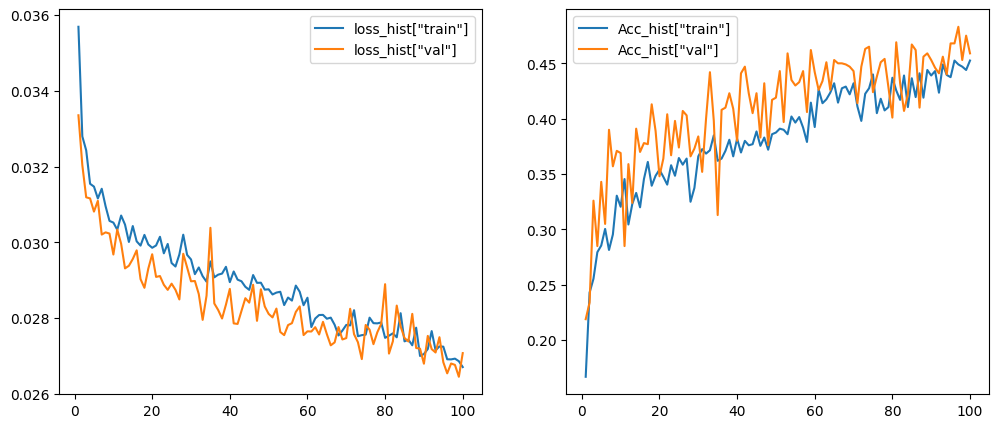

In [126]:
metric_train_hist2 = []
metric_val_hist2 = []
for i in range(len(metric_hist2['train'])):
    metric_train_hist2.append((float)(metric_hist2['train'][i]))
for i in range(len(metric_hist2['val'])):
    metric_val_hist2.append((float)(metric_hist2['val'][i]))
# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.lineplot(x=[*range(1,len(loss_hist2["train"])+1)],y=loss_hist2["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,len(loss_hist2["val"])+1)],y=loss_hist2["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,len(metric_train_hist2)+1)],y=metric_train_hist2,ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,len(metric_val_hist2)+1)],y=metric_val_hist2,ax=ax[1],label='Acc_hist["val"]')

In [127]:
loss_func = nn.CrossEntropyLoss()
test_loss2, test_metric2 = loss_epoch(cnn_model2,loss_func,test_loader)

print(f"Test loss: {test_loss2}. Accurracy for test: {float(test_metric2)*100}")

Test loss: 0.023269258431025914. Accurracy for test: 47.32857048511505


In [129]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# define function For Classification Report
import torch
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# define function For Classification Report
def Ture_and_Pred(x, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in x:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, pred = outputs.topk(1, 1, True, True)
        pred = pred.t()

        y_true.extend(labels)
        y_pred.extend(pred.detach().cpu())


    y_pred2 = []
    y_true2 = []
    for el in y_pred:
        y_pred2.extend(el.tolist())
    y_true = list(map(lambda x: int(x), y_true))


    return y_true, y_pred2


# check confusion matrix for error analysis
y_true2, y_pred2 = Ture_and_Pred(val_loader, cnn_model2)

In [130]:
f1_score5 = f1_score(y_true, y_pred, average='macro')
accuracy_score5 = accuracy_score(y_true, y_pred)
precision_score5 = precision_score(y_true, y_pred, average='macro')
recall_score5 = recall_score(y_true, y_pred, average='macro')

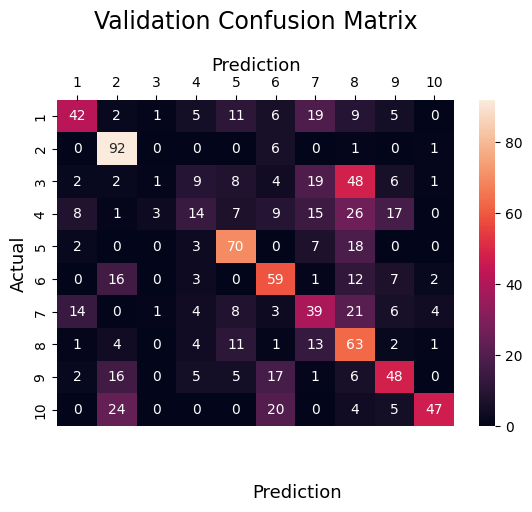

In [131]:
cm = confusion_matrix(y_true2,y_pred2)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=list(range(1,11)),
            yticklabels=list(range(1,11)))
plt.ylabel('Actual', fontsize=13)
plt.title('Validation Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

In [132]:
y_true2, y_pred2 = Ture_and_Pred(test_loader, cnn_model2)

In [133]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
f1_score6 = f1_score(y_true2, y_pred2, average='macro')
accuracy_score6 = accuracy_score(y_true2, y_pred2)
precision_score6 = precision_score(y_true2, y_pred2, average='macro')
recall_score6 = recall_score(y_true2, y_pred2, average='macro')

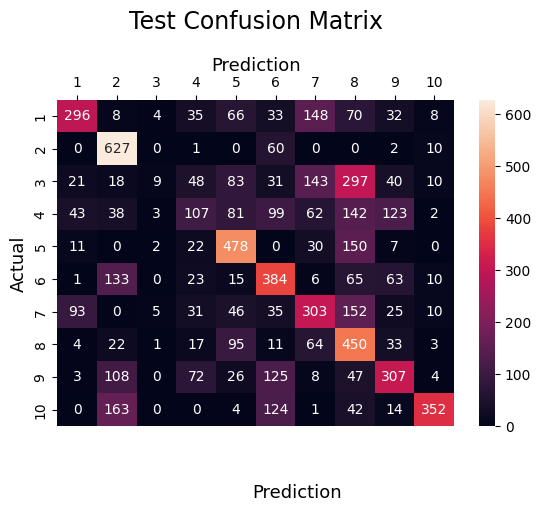

In [134]:
cm = confusion_matrix(y_true2,y_pred2)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=list(range(1,11)),
            yticklabels=list(range(1,11)))
plt.ylabel('Actual', fontsize=13)
plt.title('Test Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

In [135]:
from prettytable import PrettyTable


table = PrettyTable(["model", "epoch", "optimizer", "lr_change", "f_loss", "modifications", "Dataset Type",  "Accuracy",  "F1-score", "Precision", "Recall"])
table.add_row([f"CNN", "100", "optim.Adam() with lr=3e-4, weight_decay=1e-4", "ReduceLROnPlateau with mode='min',factor=0.5,patience=4","nn.CrossEntropyLoss(label_smoothing=0.1)", "None", "validation", accuracy_score1, f1_score1, precision_score1, recall_score1 ])
table.add_row([f"CNN","100", "optim.Adam() with lr=3e-4, weight_decay=1e-4", "ReduceLROnPlateau with mode='min',factor=0.5,patience=4", "nn.CrossEntropyLoss(label_smoothing=0.1)", "None", "test", accuracy_score2, f1_score2, precision_score2, recall_score2])

table.add_row([f"CNN", "50","optim.Adam() with lr=3e-4, weight_decay=1e-4", "ReduceLROnPlateau with mode='min',factor=0.5,patience=4","nn.CrossEntropyLoss(label_smoothing=0.1)", "Frozen layers except FC", "validation", accuracy_score9, f1_score9, precision_score9, recall_score9 ])
table.add_row([f"CNN", "50","optim.Adam() with lr=3e-4, weight_decay=1e-4", "ReduceLROnPlateau with mode='min',factor=0.5,patience=4", "nn.CrossEntropyLoss(label_smoothing=0.1)", "Frozen layers except FC", "test", accuracy_score10, f1_score10, precision_score10, recall_score10])

table.add_row([f"CNN", "50","optim.Adam() with lr=3e-4, weight_decay=1e-4", "ReduceLROnPlateau with mode='min',factor=0.5,patience=4","nn.CrossEntropyLoss(label_smoothing=0.1)", "Different LR for FC layers", "validation", accuracy_score3, f1_score3, precision_score3, recall_score3 ])
table.add_row([f"CNN", "50","optim.Adam() with lr=3e-4, weight_decay=1e-4", "ReduceLROnPlateau with mode='min',factor=0.5,patience=4", "nn.CrossEntropyLoss(label_smoothing=0.1)", "Different LR for FC layers", "test", accuracy_score4, f1_score4, precision_score4, recall_score4])

table.add_row([f"MLP", "100", "optim.Adam() with lr=3e-4, weight_decay=1e-4", "ReduceLROnPlateau with mode='min',factor=0.5,patience=4","nn.CrossEntropyLoss(label_smoothing=0.1)", "None", "validation", accuracy_score5, f1_score5, precision_score5, recall_score5 ])
table.add_row([f"MLP", "100", "optim.Adam() with lr=3e-4, weight_decay=1e-4", "ReduceLROnPlateau with mode='min',factor=0.5,patience=4", "nn.CrossEntropyLoss(label_smoothing=0.1)", "None", "test", accuracy_score6, f1_score6, precision_score6, recall_score6])
print(table)

+-------+-------+----------------------------------------------+---------------------------------------------------------+------------------------------------------+----------------------------+--------------+--------------------+---------------------+--------------------+--------------------+
| model | epoch |                  optimizer                   |                        lr_change                        |                  f_loss                  |       modifications        | Dataset Type |      Accuracy      |       F1-score      |     Precision      |       Recall       |
+-------+-------+----------------------------------------------+---------------------------------------------------------+------------------------------------------+----------------------------+--------------+--------------------+---------------------+--------------------+--------------------+
|  CNN  |  100  | optim.Adam() with lr=3e-4, weight_decay=1e-4 | ReduceLROnPlateau with mode='min',factor=0.5,patie